TODO:
validate u-net architecture for baseline
for improved model:
instead of using accuracy per image, check whether the segmentation is correct. F-measure, jaccard, housedolf distance.
Determine what kind of data augmentation is useful and implement it.
For baseline maybe use accuracy, then move to dice or something.

In [16]:
import os
import torch
import pathlib
import matplotlib
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import numpy as np

from dataset import SegmentationDataset, get_dataloaders

In [17]:
# Define transformations for images and masks
# Resize all images and masks to the same size for batching
target_size = (256, 256)  # You can adjust this size as needed

image_transform = transforms.Compose([
    transforms.Resize(target_size),  # Resize to fixed size
    transforms.ToTensor(),  # Converts to float and scales to [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# For masks: resize, convert to tensor (float), then convert 0/255 to 0/1
mask_transform = transforms.Compose([
    transforms.Resize(target_size),  # Resize to same size as images
    transforms.ToTensor(),  # Converts to float and scales to [0,1] (so 255 becomes 1.0)
    transforms.Lambda(lambda x: (x > 0.5).float())  # Convert to binary: 0 or 1
])


In [18]:
# Create the dataset
dataset = SegmentationDataset(
    images_dir='data/original',
    masks_dir='data/gt',
    image_transform=image_transform,
    mask_transform=mask_transform
)

train_loader, val_loader, eval_loader = get_dataloaders(dataset)

print(f"Train samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Evaluation samples: {len(eval_loader.dataset)}")
print(f"Total samples: {len(train_loader.dataset) + len(val_loader.dataset) + len(eval_loader.dataset)}")

Train samples: 630
Validation samples: 180
Evaluation samples: 90
Total samples: 900


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [20]:
class UNet(nn.Module):
    def __init__(self, img_size, num_classes):
        super(UNet, self).__init__()
        
        # Encoder (Contracting Path)
        self.enc1 = EncoderBlock(3, 64)      # 256x256 -> 128x128
        self.enc2 = EncoderBlock(64, 128)    # 128x128 -> 64x64
        self.enc3 = EncoderBlock(128, 256)   # 64x64 -> 32x32
        self.enc4 = EncoderBlock(256, 512)   # 32x32 -> 16x16
        
        # Bottleneck
        self.bottleneck = EncoderBlock(512, 1024)  # 16x16 -> 8x8
        
        # Decoder (Expanding Path) with skip connections
        self.dec4 = DecoderBlock(1024, 512)  # 8x8 -> 16x16 (skip from enc4)
        self.dec3 = DecoderBlock(512, 256)   # 16x16 -> 32x32 (skip from enc3)
        self.dec2 = DecoderBlock(256, 128)   # 32x32 -> 64x64 (skip from enc2)
        self.dec1 = DecoderBlock(128, 64)    # 64x64 -> 128x128 (skip from enc1)
        
        # Final upsampling to original size
        self.final_upsample = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)
        
    def forward(self, x):
        # Encoder path
        e1, skip1 = self.enc1(x)      # 256x256 -> 128x128, 64 channels
        e2, skip2 = self.enc2(e1)    # 128x128 -> 64x64, 128 channels
        e3, skip3 = self.enc3(e2)    # 64x64 -> 32x32, 256 channels
        e4, skip4 = self.enc4(e3)    # 32x32 -> 16x16, 512 channels
        
        # Bottleneck
        b, _ = self.bottleneck(e4)    # 16x16 -> 8x8, 1024 channels
        
        # Decoder path with skip connections
        d4 = self.dec4(b, skip4)      # 8x8 -> 16x16, 512 channels
        d3 = self.dec3(d4, skip3)      # 16x16 -> 32x32, 256 channels
        d2 = self.dec2(d3, skip2)      # 32x32 -> 64x64, 128 channels
        d1 = self.dec1(d2, skip1)      # 64x64 -> 128x128, 64 channels
        
        # Final upsampling and classification
        x = self.final_upsample(d1)   # 128x128 -> 256x256, 32 channels
        x = self.final_conv(x)        # 256x256 -> 256x256, 1 channel
        x = torch.sigmoid(x)
        
        return x


class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        skip = x  # Store for skip connection
        x = self.pool(x)
        return x, skip


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        
        # Upsampling
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        
        # Convolutions after concatenation - Fixed input channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x, skip):
        # Upsample
        x = self.up(x)
        
        # Ensure skip connection has the same spatial dimensions
        if x.shape[2:] != skip.shape[2:]:
            skip = F.interpolate(skip, size=x.shape[2:], mode='bilinear', align_corners=False)
        
        # Concatenate with skip connection
        x = torch.cat([x, skip], dim=1)
        
        # Convolutions
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        
        return x


In [21]:
img_size = target_size  # Height, Width - matches your target_size
num_classes = 1         # Single channel output for binary segmentation (0 or 1)
model = UNet(img_size, num_classes)

In [22]:
# Define loss function and optimizer for segmentation
import torch.optim as optim

# Binary Cross Entropy Loss for segmentation
criterion = nn.BCELoss()

# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Loss function and optimizer defined:")
print(f"Loss: {criterion}")
print(f"Optimizer: {optimizer}")


Loss function and optimizer defined:
Loss: BCELoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [23]:
# Test the model with actual data from the dataloader
model.eval()  # Set to evaluation mode

# Get a batch from the dataloader
for images, masks in train_loader:
    print(f"Testing with real data:")
    print(f"Input images shape: {images.shape}")
    print(f"Target masks shape: {masks.shape}")
    
    # Forward pass
    with torch.no_grad():
        outputs = model(images)
        print(f"Model output shape: {outputs.shape}")
        print(f"Model output range: [{outputs.min():.4f}, {outputs.max():.4f}]")
        
        # Calculate loss
        loss = criterion(outputs, masks)
        print(f"Sample loss: {loss.item():.4f}")
        
        # Check if shapes match
        if outputs.shape == masks.shape:
            print("Model output shape matches target mask shape!")
        else:
            print("Shape mismatch!")
            print(f"Expected: {masks.shape}, Got: {outputs.shape}")
    
    break  # Only test with first batch


Testing with real data:
Input images shape: torch.Size([8, 3, 256, 256])
Target masks shape: torch.Size([8, 1, 256, 256])
Model output shape: torch.Size([8, 1, 256, 256])
Model output range: [0.4647, 0.4792]
Sample loss: 0.6566
Model output shape matches target mask shape!


In [24]:
# Training function
def train_epoch(model, dataloader, criterion, optimizer, device='cpu'):
    model.train()
    total_loss = 0.0
    num_batches = 0
    
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

# Validation function
def validate_epoch(model, dataloader, criterion, device='cpu'):
    model.eval()
    total_loss = 0.0
    num_batches = 0
    
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            total_loss += loss.item()
            num_batches += 1
    
    return total_loss / num_batches

print("Training and validation functions defined!")


Training and validation functions defined!


In [25]:
# Test the U-Net model
print("Testing the U-Net model...")

# Create a new U-Net model instance
model_unet = UNet(img_size, num_classes)

# Test with sample input
sample_input = torch.randn(1, 3, 256, 256)
with torch.no_grad():
    sample_output = model_unet(sample_input)
    print(f"✅ Sample test passed!")
    print(f"Input shape: {sample_input.shape}")
    print(f"Output shape: {sample_output.shape}")
    print(f"Output range: [{sample_output.min():.4f}, {sample_output.max():.4f}]")

# Test with real data
print("\nTesting with real data...")
model_unet.eval()
for images, masks in train_loader:
    with torch.no_grad():
        outputs = model_unet(images)
        print(f"✅ Real data test passed!")
        print(f"Input shape: {images.shape}")
        print(f"Target shape: {masks.shape}")
        print(f"Output shape: {outputs.shape}")
        
        # Test loss calculation
        loss = criterion(outputs, masks)
        print(f"Loss: {loss.item():.4f}")
    break

print("\n🎉 U-Net model is working correctly!")
print(f"Model parameters: {sum(p.numel() for p in model_unet.parameters()):,}")

# Print model architecture summary
print("\nU-Net Architecture:")
print("Encoder: 3→64→128→256→512→1024")
print("Decoder: 1024→512→256→128→64→32→1")
print("Skip connections: ✅")
print("Concatenation: ✅")
print("U-shaped: ✅")


Testing the U-Net model...
✅ Sample test passed!
Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 1, 256, 256])
Output range: [0.3707, 0.7207]

Testing with real data...
✅ Real data test passed!
Input shape: torch.Size([8, 3, 256, 256])
Target shape: torch.Size([8, 1, 256, 256])
Output shape: torch.Size([8, 1, 256, 256])
Loss: 0.7258

🎉 U-Net model is working correctly!
Model parameters: 31,051,713

U-Net Architecture:
Encoder: 3→64→128→256→512→1024
Decoder: 1024→512→256→128→64→32→1
Skip connections: ✅
Concatenation: ✅
U-shaped: ✅


In [26]:
# Set device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("mps")
print(f"Using device: {device}")

# Move model to device
model = model.to(device)

# Training parameters
num_epochs = 10
best_val_loss = float('inf')

print("Starting training...")
for epoch in range(num_epochs):
    # Training
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation
    val_loss = validate_epoch(model, val_loader, criterion, device)
    
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_segmentation_model.pth')
        print(f"  New best model saved! (Val Loss: {val_loss:.4f})")
    
    print("-" * 50)

print("Training completed!")



Using device: mps
Starting training...
Epoch 1/10:
  Train Loss: 0.3778
  Val Loss: 0.3315
  New best model saved! (Val Loss: 0.3315)
--------------------------------------------------
Epoch 2/10:
  Train Loss: 0.2879
  Val Loss: 0.2471
  New best model saved! (Val Loss: 0.2471)
--------------------------------------------------
Epoch 3/10:
  Train Loss: 0.2688
  Val Loss: 0.2595
--------------------------------------------------
Epoch 4/10:
  Train Loss: 0.2602
  Val Loss: 0.2240
  New best model saved! (Val Loss: 0.2240)
--------------------------------------------------
Epoch 5/10:
  Train Loss: 0.2404
  Val Loss: 0.2327
--------------------------------------------------
Epoch 6/10:
  Train Loss: 0.2416
  Val Loss: 0.2125
  New best model saved! (Val Loss: 0.2125)
--------------------------------------------------
Epoch 7/10:
  Train Loss: 0.2360
  Val Loss: 0.2328
--------------------------------------------------
Epoch 8/10:
  Train Loss: 0.2146
  Val Loss: 0.2497
----------------

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, dataloader, num_images=5, device='cpu'):
    """
    Visualize model predictions on evaluation set
    
    Args:
        model: Trained U-Net model
        dataloader: Evaluation dataloader
        num_images: Number of images to display
        device: Device to run inference on
    """
    model.eval()
    
    # Get first num_images from dataloader
    images_to_show = []
    masks_to_show = []
    predictions_to_show = []
    
    with torch.no_grad():
        for i, (image, mask) in enumerate(dataloader):
            if i >= num_images:
                break
                
            # Move to device
            image = image.to(device)
            
            # Get prediction
            prediction = model(image)
            
            # Convert to numpy for visualization
            image_np = image[0].cpu().numpy().transpose(1, 2, 0)
            mask_np = mask[0].cpu().numpy().squeeze()
            pred_np = prediction[0].cpu().numpy().squeeze()
            
            # Denormalize image (reverse ImageNet normalization)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image_np = image_np * std + mean
            image_np = np.clip(image_np, 0, 1)
            
            images_to_show.append(image_np)
            masks_to_show.append(mask_np)
            predictions_to_show.append(pred_np)
    
    # Create visualization
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5*num_images))
    if num_images == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_images):
        # Original image
        axes[i, 0].imshow(images_to_show[i])
        axes[i, 0].set_title(f'Original Image {i+1}')
        axes[i, 0].axis('off')
        
        # Ground truth mask
        axes[i, 1].imshow(masks_to_show[i], cmap='gray')
        axes[i, 1].set_title(f'Ground Truth {i+1}')
        axes[i, 1].axis('off')
        
        # Prediction
        axes[i, 2].imshow(predictions_to_show[i], cmap='gray')
        axes[i, 2].set_title(f'Prediction {i+1}')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return images_to_show, masks_to_show, predictions_to_show

def calculate_metrics(prediction, ground_truth, threshold=0.5):
    """
    Calculate segmentation metrics
    
    Args:
        prediction: Model prediction (0-1)
        ground_truth: Ground truth mask (0-1)
        threshold: Threshold for binary prediction
    
    Returns:
        dict: Dictionary containing metrics
    """
    # Convert to binary
    pred_binary = (prediction > threshold).astype(np.uint8)
    gt_binary = ground_truth.astype(np.uint8)
    
    # Calculate metrics
    intersection = np.logical_and(pred_binary, gt_binary).sum()
    union = np.logical_or(pred_binary, gt_binary).sum()
    
    # IoU (Jaccard Index)
    iou = intersection / (union + 1e-8)
    
    # Dice Coefficient
    dice = (2 * intersection) / (pred_binary.sum() + gt_binary.sum() + 1e-8)
    
    # Accuracy
    accuracy = np.mean(pred_binary == gt_binary)
    
    return {
        'IoU': iou,
        'Dice': dice,
        'Accuracy': accuracy
    }

print("Visualization functions defined!")


Visualization functions defined!


Visualizing predictions on evaluation set...


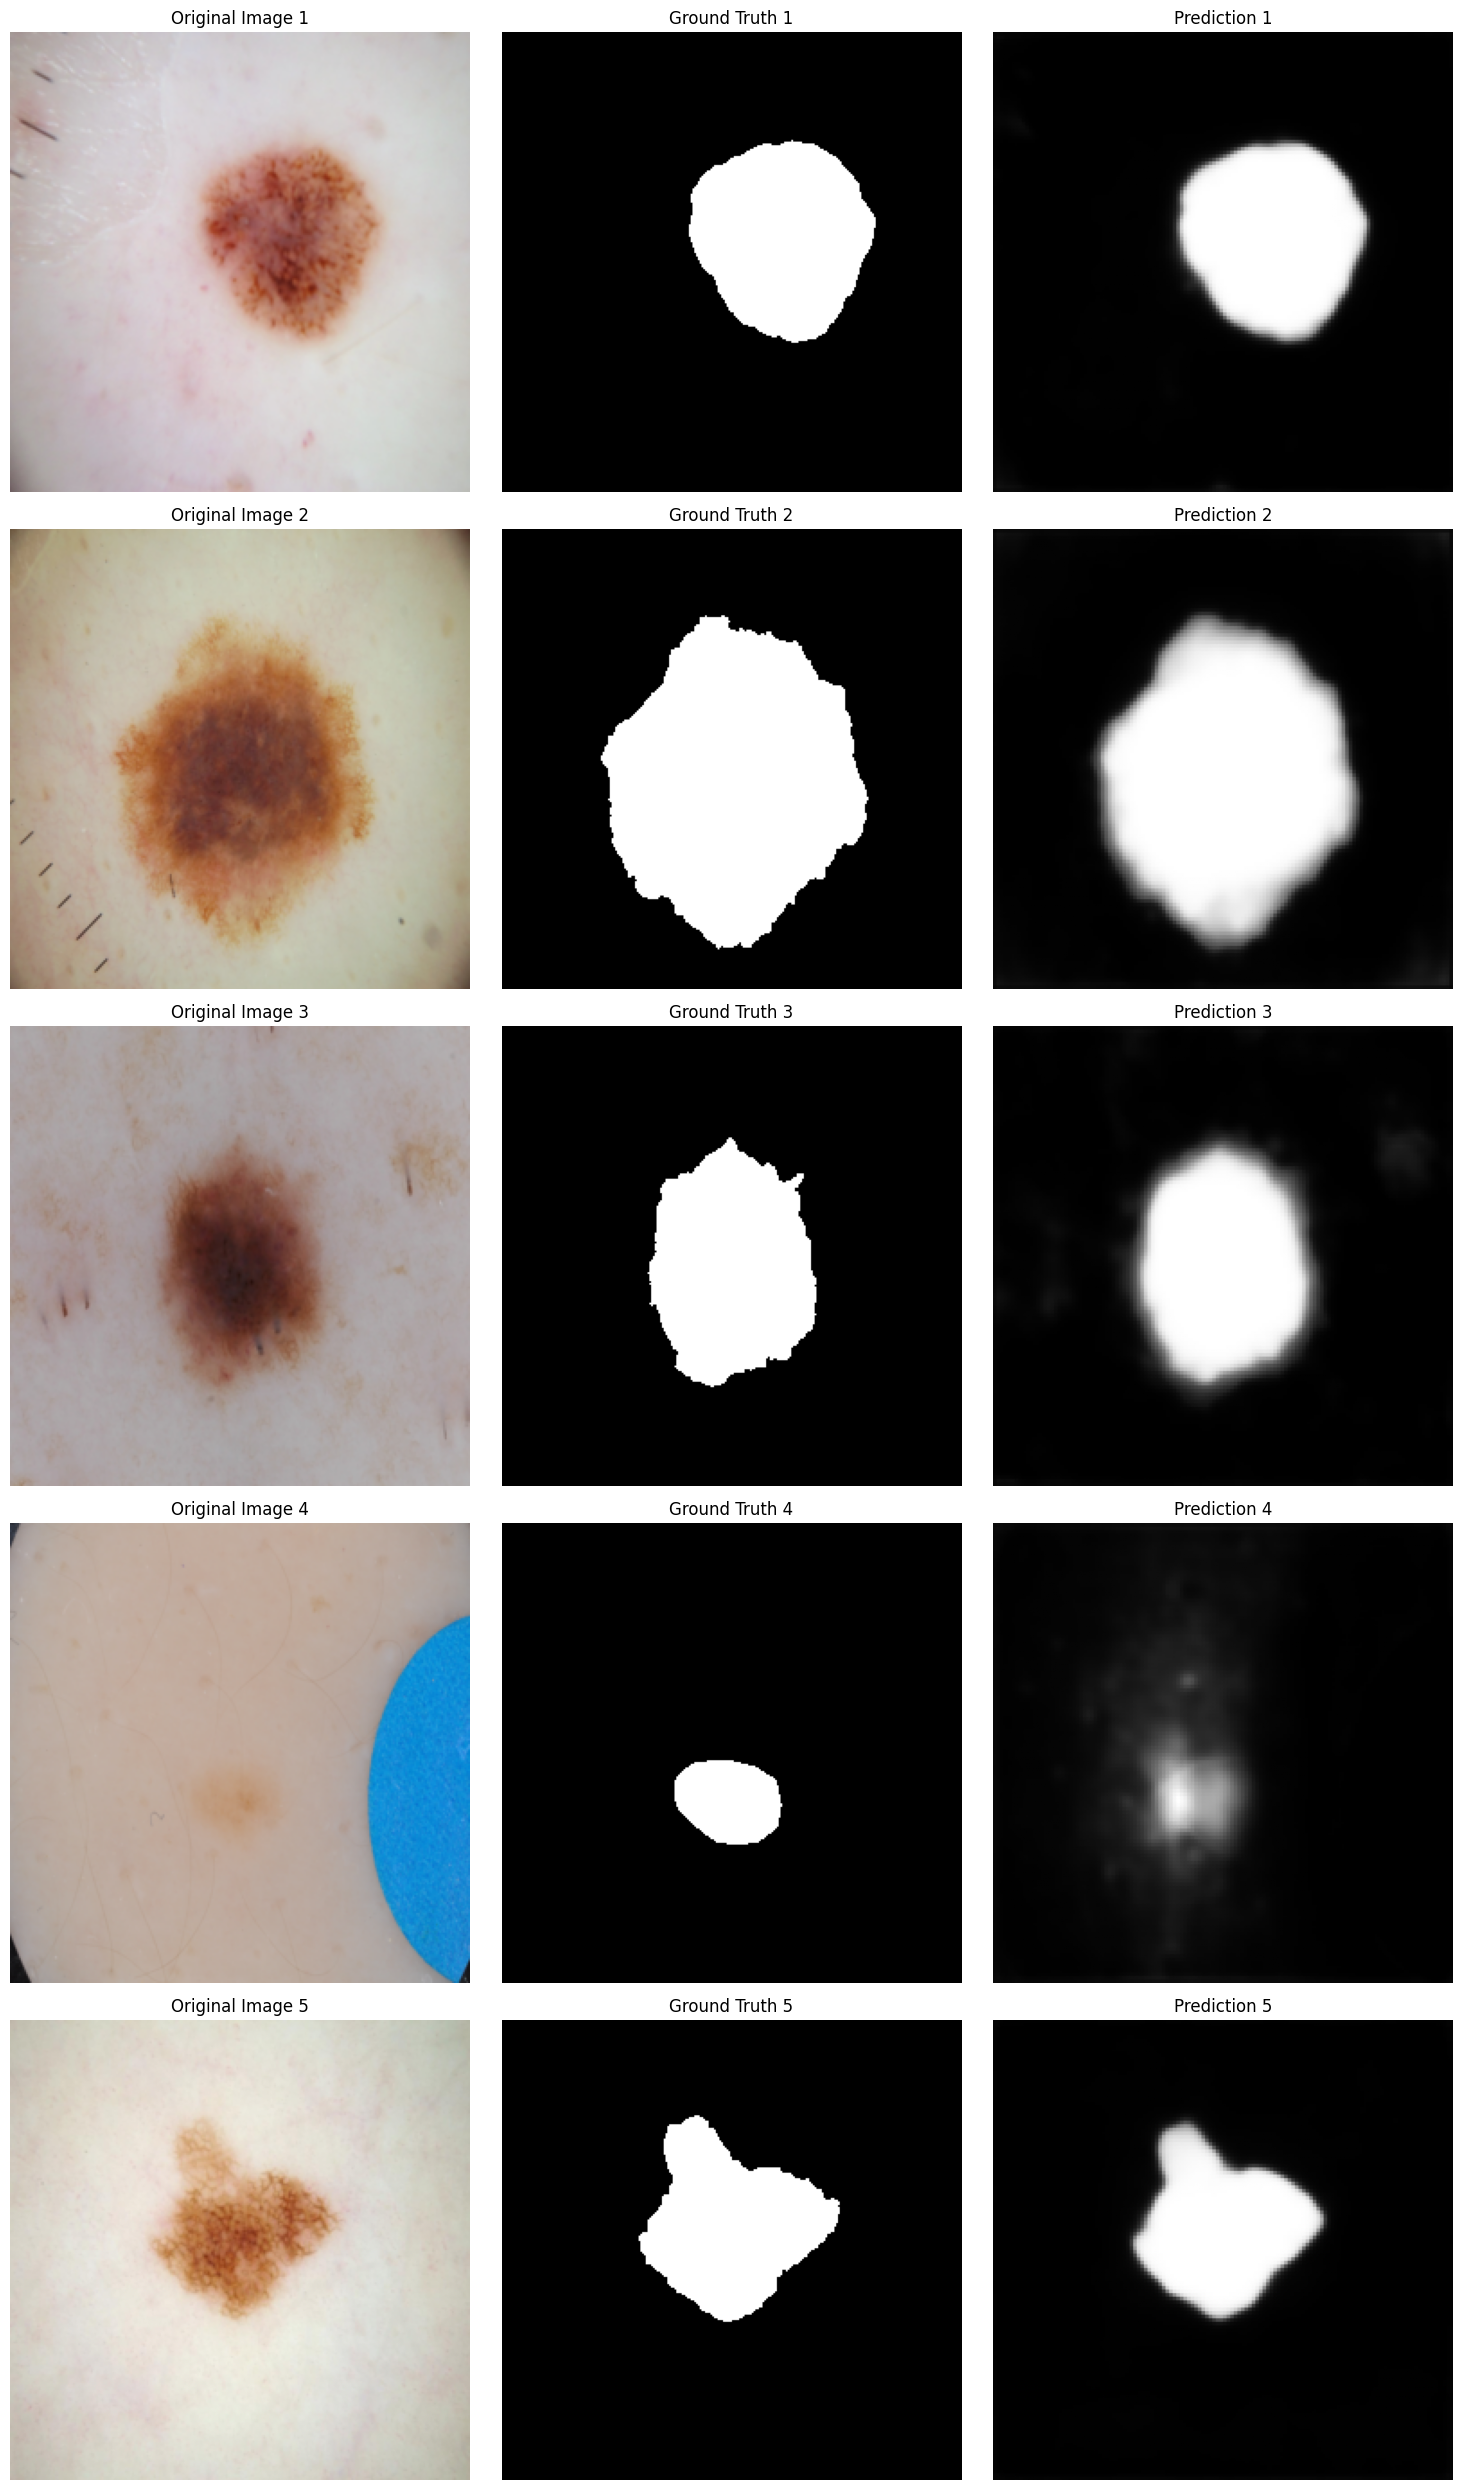


Calculating metrics for each prediction:
Image 1:
  IoU: 0.9677
  Dice: 0.9836
  Accuracy: 0.9957

Image 2:
  IoU: 0.9477
  Dice: 0.9731
  Accuracy: 0.9851

Image 3:
  IoU: 0.9455
  Dice: 0.9720
  Accuracy: 0.9919

Image 4:
  IoU: 0.0261
  Dice: 0.0509
  Accuracy: 0.9670

Image 5:
  IoU: 0.9147
  Dice: 0.9555
  Accuracy: 0.9904

Average Metrics:
  IoU: 0.7603
  Dice: 0.7870
  Accuracy: 0.9860


In [34]:
# Load the best model (if you want to load from saved checkpoint)
# model.load_state_dict(torch.load('best_segmentation_model.pth'))

# Visualize predictions on evaluation set
print("Visualizing predictions on evaluation set...")
images, masks, predictions = visualize_predictions(
    model, eval_loader, num_images=5, device=device
)

# Calculate metrics for each prediction
print("\nCalculating metrics for each prediction:")
for i in range(len(predictions)):
    metrics = calculate_metrics(predictions[i], masks[i])
    print(f"Image {i+1}:")
    print(f"  IoU: {metrics['IoU']:.4f}")
    print(f"  Dice: {metrics['Dice']:.4f}")
    print(f"  Accuracy: {metrics['Accuracy']:.4f}")
    print()

# Calculate average metrics
avg_iou = np.mean([calculate_metrics(pred, mask)['IoU'] for pred, mask in zip(predictions, masks)])
avg_dice = np.mean([calculate_metrics(pred, mask)['Dice'] for pred, mask in zip(predictions, masks)])
avg_acc = np.mean([calculate_metrics(pred, mask)['Accuracy'] for pred, mask in zip(predictions, masks)])

print(f"Average Metrics:")
print(f"  IoU: {avg_iou:.4f}")
print(f"  Dice: {avg_dice:.4f}")
print(f"  Accuracy: {avg_acc:.4f}")
